In [1]:
# === CLEAN CELL 1: Load Full FASTA, STRING PPI, and Biomni Features ===

import pandas as pd
import numpy as np
import networkx as nx
from Bio import SeqIO

print("=== Step 1: Loading FULL Proteome FASTA ===")

fasta_path = "Flavobacterium sp. MO_0223_q7L1K.faa"
fasta_records = list(SeqIO.parse(fasta_path, "fasta"))

print(f"Loaded {len(fasta_records)} full proteome sequences.")

# Build FASTA dictionary → protein_id → sequence
fasta_seq_dict = {rec.id: str(rec.seq) for rec in fasta_records}

print("\n=== Step 2: Loading STRING PPI ===")

string_df = pd.read_csv("string_interactions.tsv", sep="\t")
string_df = string_df[["#node1", "node2", "combined_score"]]
string_df["combined_score"] = string_df["combined_score"].astype(float)

print(f"STRING edges loaded: {len(string_df)}")

print("\n=== Step 3: Building STRING graph ===")

G = nx.Graph()

for _, row in string_df.iterrows():
    G.add_edge(
        row["#node1"],
        row["node2"],
        weight=row["combined_score"]
    )

print(f"Graph built: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

print("\n=== Step 4: Loading Biomni Features ===")

biomni_df = pd.read_csv("complete_vaccine_analysis_all_3257_proteins.csv")
biomni_df = biomni_df.set_index("protein_id")

feature_cols = [
    "signal_peptide_strength", "number_of_tm_domains", "cysteine_content",
    "gravy_hydrophobicity", "protein_length", "molecular_weight_da",
    "instability_index", "isoelectric_point", "vaccine_score"
]

# Priority classes (0–3)
priority_map = {
    "Very Low": 0,
    "Low": 1,
    "Medium": 2,
    "High": 3
}

print("Cell 1 completed successfully.")


=== Step 1: Loading FULL Proteome FASTA ===
Loaded 3257 full proteome sequences.

=== Step 2: Loading STRING PPI ===
STRING edges loaded: 32630

=== Step 3: Building STRING graph ===
Graph built: 1607 nodes, 16315 edges

=== Step 4: Loading Biomni Features ===
Cell 1 completed successfully.


In [2]:
# === CLEAN CELL 2: Remap STRING IDs → MO_0223 FASTA/Biomni IDs ===

print("=== Step 5: Loading STRING → FASTA mapping ===")

mapping_df = pd.read_csv("string_mapping.tsv", sep="\t")
print("Mapping columns:", list(mapping_df.columns))

# The correct mapping:
# preferredName (STRING ID) → queryItem (your MO_0223 protein ID)
string_to_fasta_map = dict(zip(mapping_df["preferredName"], mapping_df["queryItem"]))
print(f"Total valid mappings: {len(string_to_fasta_map)}")

print("\nSample original STRING graph node IDs:", list(G.nodes)[:10])

# Remap the graph
G_remapped = nx.relabel_nodes(G, string_to_fasta_map, copy=True)
print(f"After remapping: {G_remapped.number_of_nodes()} nodes, {G_remapped.number_of_edges()} edges")

# === Add all Biomni proteins (3257) as nodes if missing ===
isolated_added = 0

for pid in biomni_df.index:
    if pid not in G_remapped:
        G_remapped.add_node(pid)
        isolated_added += 1

print(f"Added {isolated_added} isolated Biomni-only nodes.")


# === Attach Biomni features + FASTA sequences + isolate labels ===
missing_biomni = 0
missing_seq = 0

for node in G_remapped.nodes:

    # ---- Biomni Features ----
    if node in biomni_df.index:
        row = biomni_df.loc[node]
        G_remapped.nodes[node]["features"] = row[feature_cols].astype(float).values
        G_remapped.nodes[node]["priority"] = priority_map[row["priority"]]
    else:
        G_remapped.nodes[node]["features"] = np.zeros(len(feature_cols), dtype=float)
        G_remapped.nodes[node]["priority"] = -1  # Unknown class
        missing_biomni += 1

    # ---- Sequence for ESM ----
    seq = fasta_seq_dict.get(node)
    G_remapped.nodes[node]["sequence"] = seq
    if seq is None:
        missing_seq += 1

# === Mark isolated nodes explicitly ===
for node in G_remapped.nodes:
    G_remapped.nodes[node]["isolated"] = (G_remapped.degree(node) == 0)

print(f"Nodes missing Biomni features: {missing_biomni}")
print(f"Nodes missing FASTA sequences: {missing_seq}")

print("\nCell 2 completed successfully.")


=== Step 5: Loading STRING → FASTA mapping ===
Mapping columns: ['#queryIndex', 'queryItem', 'stringId', 'identity', 'bitscore', 'preferredName', 'annotation']
Total valid mappings: 1644

Sample original STRING graph node IDs: ['AEW84859.2', 'sdhA', 'atpD', 'AEW85750.1', 'dnaJ', 'AEW86571.1', 'AEW86329.1', 'AEW86639.1', 'ftsH', 'AEW85647.1']
After remapping: 1607 nodes, 16315 edges
Added 1650 isolated Biomni-only nodes.
Nodes missing Biomni features: 0
Nodes missing FASTA sequences: 0

Cell 2 completed successfully.


In [6]:
# === CELL 3A (OPTIONAL - RUN ONCE): Generate ESM-2 35M Embeddings and Save ===
"""
This cell computes ESM-2 embeddings for all proteins in G_remapped
and saves them to: esm2_embeddings.h5

DO NOT RUN if embeddings already exist.
"""

import torch
import numpy as np
import h5py
from tqdm import tqdm
import esm
import os

OUTPUT_FILE = "esm2_embeddings.h5"

# ---- Load lightweight ESM-2 35M ----
print("Loading ESM-2 35M model...")
model, alphabet = esm.pretrained.esm2_t12_35M_UR50D()
model.eval()
batch_converter = alphabet.get_batch_converter()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

EMB_DIM = model.embed_dim  # ~480

# ---- Prepare sequences ----
full_seq_dict = fasta_seq_dict   # from Cell 1
all_nodes = list(G_remapped.nodes)

def get_seq(pid):   # fallback for missing sequences
    return full_seq_dict.get(pid, "A")

seq_lengths = {pid: len(get_seq(pid)) for pid in all_nodes}

# ---- Prepare HDF5 file ----
if os.path.exists(OUTPUT_FILE):
    h5 = h5py.File(OUTPUT_FILE, "a")
else:
    h5 = h5py.File(OUTPUT_FILE, "w")

# Create entries if missing
for pid in all_nodes:
    if pid not in h5:
        h5.create_dataset(pid, shape=(EMB_DIM,), dtype="float32")

# Identify proteins that still need embedding
to_process = [pid for pid in all_nodes if np.sum(h5[pid][:]) == 0]
print("Proteins left to embed:", len(to_process))

MAX_TOKENS = 2000

def batch_pids(pids):
    batch, toks = [], 0
    for pid in pids:
        L = seq_lengths[pid]
        if toks + L > MAX_TOKENS and batch:
            yield batch
            batch, toks = [], 0
        batch.append(pid)
        toks += L
    if batch:
        yield batch

# ---- Main embedding loop ----
with torch.no_grad():
    for batch in tqdm(batch_pids(to_process), total=len(to_process)):
        seq_batch = [(pid, get_seq(pid)) for pid in batch]
        labels, strs, tokens = batch_converter(seq_batch)
        tokens = tokens.to(device)

        out = model(tokens, repr_layers=[model.num_layers])
        reps = out["representations"][model.num_layers]

        for i, (pid, seq) in enumerate(seq_batch):
            L = len(seq)
            emb = reps[i, 1:L+1].mean(0).cpu().numpy().astype("float32")
            h5[pid][:] = emb

        del tokens, out, reps
        torch.cuda.empty_cache()

h5.close()
print("ESM-2 embedding complete! Saved to:", OUTPUT_FILE)


Loading ESM-2 35M model...
Proteins left to embed: 0


0it [00:00, ?it/s]

ESM-2 embedding complete! Saved to: esm2_embeddings.h5


In [3]:
# === CELL 3B: Load Precomputed ESM Embeddings (FAST) ===

import h5py
import numpy as np
import os

ESM_FILE = "esm2_embeddings.h5"

print("=== Loading Precomputed ESM-2 Embeddings ===")

if not os.path.exists(ESM_FILE):
    raise FileNotFoundError(f"❌ Missing {ESM_FILE}. Run Cell 3A first.")

esm_embeddings = {}
with h5py.File(ESM_FILE, "r") as h5:
    for pid in G_remapped.nodes:   # preserve graph order
        esm_embeddings[pid] = h5[pid][:].astype(np.float32)

# Determine embedding dimension
first_pid = next(iter(esm_embeddings.keys()))
ESM_DIM = esm_embeddings[first_pid].shape[0]

print(f"Loaded embeddings for {len(esm_embeddings)} proteins.")
print("ESM-2 embedding dimension:", ESM_DIM)


=== Loading Precomputed ESM-2 Embeddings ===
Loaded embeddings for 3257 proteins.
ESM-2 embedding dimension: 480


In [4]:
# === CELL 4A: Generate Node2Vec Embeddings (RUN ONCE) ===
import random
import numpy as np
from gensim.models import Word2Vec
from tqdm import tqdm

print("=== Running Pure-Python Node2Vec (M1/M2-safe) ===")

walk_length = 20
num_walks_per_node = 10
N2V_DIM = 128

G = G_remapped
nodes = list(G.nodes())

def random_walk(graph, start):
    walk = [start]
    for _ in range(walk_length - 1):
        cur = walk[-1]
        nbrs = list(graph.neighbors(cur))
        if not nbrs:
            break
        walk.append(random.choice(nbrs))
    return walk

# ---- Generate Random Walk Corpus ----
print("Generating random walks...")
walks = []
for _ in tqdm(range(num_walks_per_node)):
    random.shuffle(nodes)
    for n in nodes:
        walks.append([str(x) for x in random_walk(G, n)])

# ---- Train Skip-Gram Model ----
print("Training Word2Vec...")
model_n2v = Word2Vec(
    sentences=walks,
    vector_size=N2V_DIM,
    window=10,
    min_count=1,
    sg=1,
    workers=4,
    epochs=5
)

# ---- Build Embedding Dictionary ----
print("Extracting embeddings...")
n2v_dict = {node: model_n2v.wv[str(node)] for node in nodes}

# Save
np.savez_compressed("node2vec_flavobacterium.npz", **n2v_dict)

print("Saved Node2Vec embeddings!")
print("Nodes:", len(n2v_dict))
print("Embedding dimension:", N2V_DIM)


=== Running Pure-Python Node2Vec (M1/M2-safe) ===
Generating random walks...


100%|██████████| 10/10 [00:00<00:00, 30.53it/s]


Training Word2Vec...


Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


Extracting embeddings...
Saved Node2Vec embeddings!
Nodes: 3257
Embedding dimension: 128


In [5]:
# === CELL 4B: Load Node2Vec Embeddings (FAST) ===

import numpy as np
import os

NODE2VEC_FILE = "node2vec_flavobacterium.npz"

print("=== Loading Node2Vec embeddings ===")

if not os.path.exists(NODE2VEC_FILE):
    raise FileNotFoundError(f"❌ Missing {NODE2VEC_FILE}. Run Node2Vec generation first.")

raw = np.load(NODE2VEC_FILE, allow_pickle=True)

node2vec_emb = {}
for pid in G_remapped.nodes:
    if pid in raw:
        node2vec_emb[pid] = raw[pid]
    else:
        # fallback for isolated/unconnected-only sequences
        node2vec_emb[pid] = np.zeros(N2V_DIM, dtype=float)

NODE2VEC_DIM = len(next(iter(node2vec_emb.values())))

print(f"Loaded Node2Vec embeddings for {len(node2vec_emb)} proteins.")
print("Node2Vec embedding dimension:", NODE2VEC_DIM)


=== Loading Node2Vec embeddings ===
Loaded Node2Vec embeddings for 3257 proteins.
Node2Vec embedding dimension: 128


In [6]:
# === CELL 5: Build Feature Sets for Comparative Experiments ===
import numpy as np
import torch
import h5py

print("=== Building Unified Feature Matrices ===")

ordered_nodes = list(G_remapped.nodes)
BIOMNI_DIM = len(feature_cols)

# ---------------------------
# 1) Load Node2Vec embeddings
# ---------------------------
NODE2VEC_FILE = "node2vec_flavobacterium.npz"
n2v_npz = np.load(NODE2VEC_FILE, allow_pickle=True)

# dictionary lookup for consistent ordering
node2vec_emb = {
    pid: n2v_npz[pid] if pid in n2v_npz.files else None
    for pid in ordered_nodes
}

# detect actual dim
some_vec = next(v for v in node2vec_emb.values() if v is not None)
NODE2VEC_DIM = len(some_vec)
print(f"Node2Vec dim = {NODE2VEC_DIM} | Loaded for {len(node2vec_emb)} proteins")


# ------------------------
# 2) Load ESM-2 embeddings
# ------------------------
ESM_FILE = "esm2_embeddings.h5"
with h5py.File(ESM_FILE, "r") as h5:
    esm_emb = {
        pid: h5[pid][:] if pid in h5 else None
        for pid in ordered_nodes
    }

# detect ESM dim
some_vec = next(v for v in esm_emb.values() if v is not None)
ESM_DIM = len(some_vec)
print(f"ESM dim = {ESM_DIM} | Loaded for {len(esm_emb)} proteins")


# -------------------------
# 3) Build all feature sets
# -------------------------
X_biomni = []
X_biomni_esm = []
X_biomni_esm_n2v = []

for pid in ordered_nodes:

    # ---- Biomni (9D) ----
    if pid in biomni_df.index:
        biom = biomni_df.loc[pid][feature_cols].values.astype(float)
    else:
        biom = np.zeros(BIOMNI_DIM, dtype=float)

    # ---- ESM (480D) ----
    esm_vec = esm_emb[pid] if esm_emb[pid] is not None else np.zeros(ESM_DIM, dtype=float)

    # ---- Node2Vec (128D) ----
    n2v_vec = node2vec_emb[pid] if node2vec_emb[pid] is not None else np.zeros(NODE2VEC_DIM, dtype=float)

    # ---- Construct feature sets ----
    X_biomni.append(biom)
    X_biomni_esm.append(np.concatenate([biom, esm_vec]))
    X_biomni_esm_n2v.append(np.concatenate([biom, esm_vec, n2v_vec]))

# Convert to torch tensors
X_biomni = torch.tensor(np.vstack(X_biomni), dtype=torch.float)
X_biomni_esm = torch.tensor(np.vstack(X_biomni_esm), dtype=torch.float)
X_biomni_esm_n2v = torch.tensor(np.vstack(X_biomni_esm_n2v), dtype=torch.float)

print("X_biomni shape:        ", X_biomni.shape)
print("X_biomni_esm shape:    ", X_biomni_esm.shape)
print("X_biomni_esm_n2v shape:", X_biomni_esm_n2v.shape)

print("\nFeature matrix build COMPLETE.")


=== Building Unified Feature Matrices ===
Node2Vec dim = 128 | Loaded for 3257 proteins
ESM dim = 480 | Loaded for 3257 proteins
X_biomni shape:         torch.Size([3257, 9])
X_biomni_esm shape:     torch.Size([3257, 489])
X_biomni_esm_n2v shape: torch.Size([3257, 617])

Feature matrix build COMPLETE.


In [7]:
# === CELL A: GNN Models for Link Prediction ===
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, SAGEConv

class GCNLinkPredictor(nn.Module):
    def __init__(self, in_dim, hidden_dim=128, out_dim=64, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, out_dim)
        self.dropout = dropout

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x  # z

    def decode(self, z, edge_label_index):
        # dot product decoder
        src = z[edge_label_index[0]]
        dst = z[edge_label_index[1]]
        return (src * dst).sum(dim=-1)  # logits

    def forward(self, x, edge_index, edge_label_index):
        z = self.encode(x, edge_index)
        return self.decode(z, edge_label_index)


class GATLinkPredictor(nn.Module):
    def __init__(self, in_dim, hidden_dim=128, out_dim=64, heads=4, dropout=0.5):
        super().__init__()
        self.conv1 = GATConv(in_dim, hidden_dim // heads, heads=heads, dropout=dropout)
        self.conv2 = GATConv(hidden_dim, out_dim, heads=1, dropout=dropout)
        self.dropout = dropout

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

    def decode(self, z, edge_label_index):
        src = z[edge_label_index[0]]
        dst = z[edge_label_index[1]]
        return (src * dst).sum(dim=-1)

    def forward(self, x, edge_index, edge_label_index):
        z = self.encode(x, edge_index)
        return self.decode(z, edge_label_index)


class GraphSAGELinkPredictor(nn.Module):
    def __init__(self, in_dim, hidden_dim=128, out_dim=64, dropout=0.5):
        super().__init__()
        self.conv1 = SAGEConv(in_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, out_dim)
        self.dropout = dropout

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

    def decode(self, z, edge_label_index):
        src = z[edge_label_index[0]]
        dst = z[edge_label_index[1]]
        return (src * dst).sum(dim=-1)

    def forward(self, x, edge_index, edge_label_index):
        z = self.encode(x, edge_index)
        return self.decode(z, edge_label_index)


/Volumes/Data/NDSU/PhD Work/Research/IME Research/AI-Energy/CCAST/Multilayer_GNN/.conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
# === CELL B: Training & Evaluation Utilities (Final Patched) ===
from sklearn.metrics import roc_auc_score, average_precision_score
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

bce_loss = nn.BCEWithLogitsLoss()


# ------------------------------
# Train One Epoch
# ------------------------------
def train_one_epoch(model, data, optimizer):
    model.train()
    optimizer.zero_grad()

    logits = model(
        data.x.to(device),
        data.edge_index.to(device),
        data.edge_label_index.to(device),
    )

    y = data.edge_label.to(device).float()
    loss = bce_loss(logits, y)
    loss.backward()
    optimizer.step()

    return loss.item()


# ------------------------------
# Eval: ROC-AUC + AP
# ------------------------------
@torch.no_grad()
def eval_auc_ap(model, data):
    model.eval()

    logits = model(
        data.x.to(device),
        data.edge_index.to(device),
        data.edge_label_index.to(device),
    )

    y_true = data.edge_label.cpu().numpy()
    y_score = torch.sigmoid(logits).cpu().numpy()

    # Edge case: if all labels are 0 or 1, AUC fails
    if len(set(y_true)) < 2:
        return 0.5, 0.5

    auc = roc_auc_score(y_true, y_score)
    ap = average_precision_score(y_true, y_score)
    return auc, ap


# ------------------------------
# Train model with early stopping
# ------------------------------
def run_single_model(
    model_name, ModelClass, in_dim,
    train_data, val_data, test_data,
    hidden_dim=128, lr=1e-3, max_epochs=50, patience=10
):

    # Instantiate model
    model = ModelClass(in_dim=in_dim, hidden_dim=hidden_dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_val_auc = 0.0
    best_test_auc = 0.0
    best_test_ap = 0.0
    best_epoch = 0
    no_improve = 0
    best_state = None

    for epoch in range(1, max_epochs + 1):
        loss = train_one_epoch(model, train_data, optimizer)
        val_auc, val_ap = eval_auc_ap(model, val_data)

        print(f"[{model_name}][Epoch {epoch}] loss={loss:.4f} val_AUC={val_auc:.3f} val_AP={val_ap:.3f}")

        # Improvement?
        if val_auc > best_val_auc + 1e-4:
            best_val_auc = val_auc
            best_epoch = epoch
            no_improve = 0

            # Compute test metrics when improved
            test_auc, test_ap = eval_auc_ap(model, test_data)
            best_test_auc = test_auc
            best_test_ap = test_ap

            # Save best model weights
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}

            # >>> NEW: save best model checkpoint <<<
            torch.save(best_state, f"{model_name}_best_model.pt")
        else:
            no_improve += 1
            if no_improve >= patience:
                print("⏹ Early stopping triggered.")
                break

    print(
        f"🏆 {model_name}: Best Val AUC={best_val_auc:.3f} "
        f"| Test AUC={best_test_auc:.3f}, AP={best_test_ap:.3f} "
        f"@ epoch {best_epoch}"
    )

    return {
        "model": model_name,
        "best_val_auc": float(best_val_auc),
        "test_auc": float(best_test_auc),
        "test_ap": float(best_test_ap),
        "best_epoch": best_epoch,
        "best_state": best_state,   # <---- IMPORTANT FOR HEATMAP LATER
    }


Using device: cpu


In [9]:
# === CELL: Train/Val/Test Split ===
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.data import Data
import torch

# Build edge_index from G_remapped
node_list = list(G_remapped.nodes)
node_to_idx = {n: i for i, n in enumerate(node_list)}

edges = []
for u, v in G_remapped.edges():
    edges.append([node_to_idx[u], node_to_idx[v]])
    edges.append([node_to_idx[v], node_to_idx[u]]) # undirected

edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

# Initial dummy feature matrix (real features assigned later in Cell C)
num_nodes = len(node_list)
X_dummy = torch.zeros((num_nodes, 1), dtype=torch.float)

data = Data(x=X_dummy, edge_index=edge_index)

splitter = RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    is_undirected=True,
    add_negative_train_samples=True
)

train_data, val_data, test_data = splitter(data)

print("Train positives:", train_data.edge_label.sum().item())
print("Val positives:  ", val_data.edge_label.sum().item())
print("Test positives: ", test_data.edge_label.sum().item())


Train positives: 13053.0
Val positives:   1631.0
Test positives:  1631.0


In [10]:
# === CELL C: Run GCN, GAT, GraphSAGE for a given feature matrix ===

def run_experiments_for_features(feature_name, X_tensor):
    print("\n" + "="*80)
    print(f"Running experiments for feature set: {feature_name}")
    print("="*80)

    # Assign node features to all splits
    train_data.x = X_tensor
    val_data.x = X_tensor
    test_data.x = X_tensor

    in_dim = X_tensor.shape[1]
    results = []

    results.append(
        run_single_model("GCN", GCNLinkPredictor, in_dim, train_data, val_data, test_data)
    )
    results.append(
        run_single_model("GAT", GATLinkPredictor, in_dim, train_data, val_data, test_data)
    )
    results.append(
        run_single_model("GraphSAGE", GraphSAGELinkPredictor, in_dim, train_data, val_data, test_data)
    )

    print("\nSummary:")
    for r in results:
        print(r)

    return results


In [11]:
# === CELL D: Run All Three Feature-Set Experiments ===

results_biomni = run_experiments_for_features("Biomni only", X_biomni)
results_biomni_esm = run_experiments_for_features("Biomni + ESM", X_biomni_esm)
results_biomni_esm_n2v = run_experiments_for_features("Biomni + ESM + Node2Vec", X_biomni_esm_n2v)



Running experiments for feature set: Biomni only
[GCN][Epoch 1] loss=351099776.0000 val_AUC=0.500 val_AP=0.500
[GCN][Epoch 2] loss=306614016.0000 val_AUC=0.500 val_AP=0.500
[GCN][Epoch 3] loss=275916416.0000 val_AUC=0.500 val_AP=0.500
[GCN][Epoch 4] loss=250088368.0000 val_AUC=0.500 val_AP=0.500
[GCN][Epoch 5] loss=221049856.0000 val_AUC=0.500 val_AP=0.500
[GCN][Epoch 6] loss=197659440.0000 val_AUC=0.500 val_AP=0.500
[GCN][Epoch 7] loss=173361184.0000 val_AUC=0.500 val_AP=0.500
[GCN][Epoch 8] loss=154971376.0000 val_AUC=0.500 val_AP=0.500
[GCN][Epoch 9] loss=138112960.0000 val_AUC=0.500 val_AP=0.500
[GCN][Epoch 10] loss=119594600.0000 val_AUC=0.500 val_AP=0.500
[GCN][Epoch 11] loss=105006552.0000 val_AUC=0.500 val_AP=0.500
⏹ Early stopping triggered.
🏆 GCN: Best Val AUC=0.500 | Test AUC=0.500, AP=0.500 @ epoch 1
[GAT][Epoch 1] loss=3190436608.0000 val_AUC=0.500 val_AP=0.500
[GAT][Epoch 2] loss=3564298496.0000 val_AUC=0.500 val_AP=0.500
[GAT][Epoch 3] loss=2809317632.0000 val_AUC=0.500

In [ ]:
%%capture cap
print(results_biomni)
print(results_biomni_esm)
print(results_biomni_esm_n2v)
with open("gnn_results_output_N.txt", "w") as f:
    f.write(cap.stdout)


In [12]:
all_results = {
    "Biomni": results_biomni,
    "Biomni_ESM": results_biomni_esm,
    "Biomni_ESM_N2V": results_biomni_esm_n2v
}


In [13]:
def pick_best_model(all_results):
    best = None
    for feat_name, result_list in all_results.items():
        for model_res in result_list:
            if best is None or model_res["best_val_auc"] > best["best_val_auc"]:
                best = {**model_res, "feature_set": feat_name}
    return best


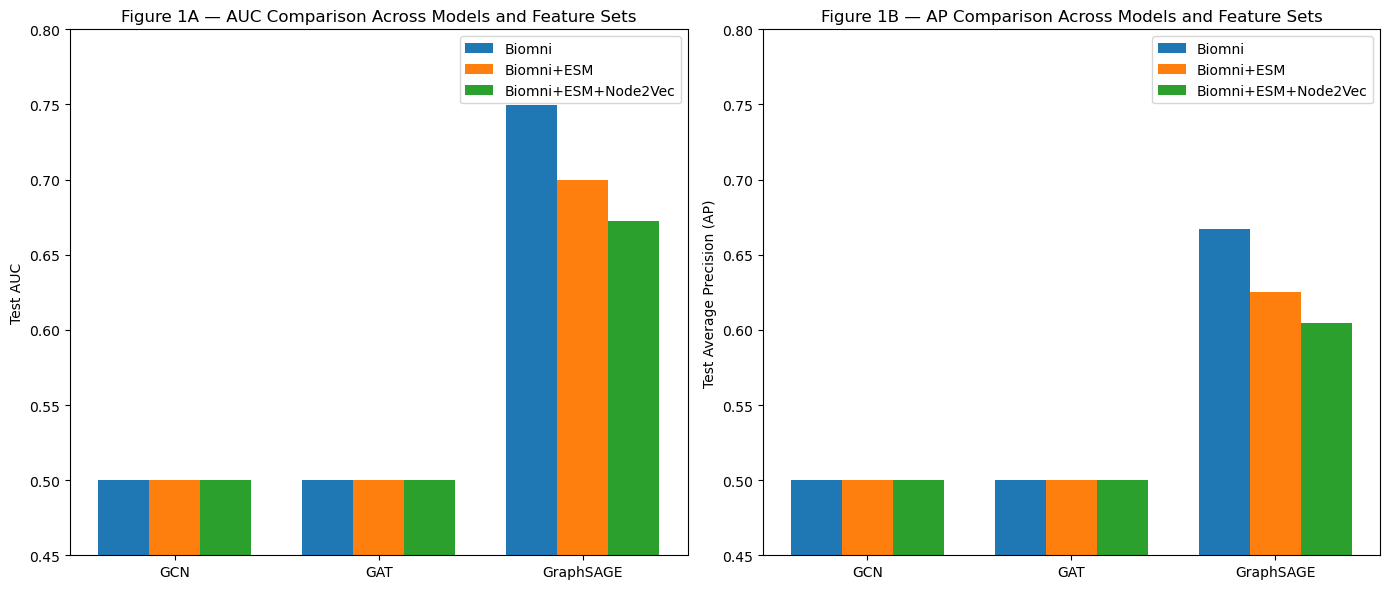

In [ ]:
# === FIGURE OPTION 1: Two Comparative Bar Charts (AUC + AP) ===
import matplotlib.pyplot as plt
import numpy as np

# Reformat results into arrays
models = ["GCN", "GAT", "GraphSAGE"]

auc_matrix = np.array([
    [r["test_auc"] for r in results_biomni],
    [r["test_auc"] for r in results_biomni_esm],
    [r["test_auc"] for r in results_biomni_esm_n2v]
])

ap_matrix = np.array([
    [r["test_ap"] for r in results_biomni],
    [r["test_ap"] for r in results_biomni_esm],
    [r["test_ap"] for r in results_biomni_esm_n2v]
])

feature_sets = ["Biomni", "Biomni+ESM", "Biomni+ESM+Node2Vec"]
x = np.arange(len(models))
width = 0.25

plt.figure(figsize=(14, 6))

# ---------------- AUC subplot ----------------
plt.subplot(1, 2, 1)
for i in range(len(feature_sets)):
    plt.bar(x + (i-1;/';====')*width, auc_matrix[i], width, label=feature_sets[i])
plt.xticks(x, models)
plt.ylabel("Test AUC")
plt.title("Figure 1A — AUC Comparison Across Models and Feature Sets")
plt.ylim(0.45, 0.80)
plt.legend()

# ---------------- AP subplot ----------------
plt.subplot(1, 2, 2)
for i in range(len(feature_sets)):
    plt.bar(x + (i-1)*width, ap_matrix[i], width, label=feature_sets[i])
plt.xticks(x, models)
plt.ylabel("Test Average Precision (AP)")
plt.title("Figure 1B — AP Comparison Across Models and Feature Sets")
plt.ylim(0.45, 0.80)
plt.legend()

plt.tight_layout()
plt.show()


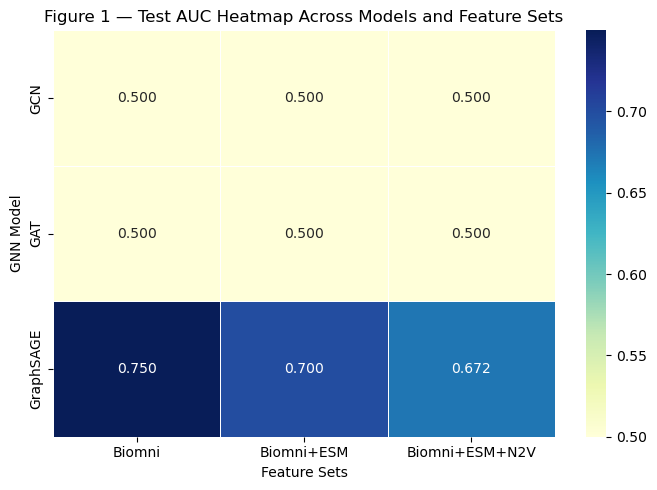

In [ ]:
# === FIGURE OPTION 3: Heatmap of AUC ===
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

heatmap_auc = pd.DataFrame({
    "Biomni":        [r["test_auc"] for r in results_biomni],
    "Biomni+ESM":    [r["test_auc"] for r in results_biomni_esm],
    "Biomni+ESM+N2V":[r["test_auc"] for r in results_biomni_esm_n2v]
}, index=["GCN", "GAT", "GraphSAGE"])

plt.figure(figsize=(7, 5))
sns.heatmap(heatmap_auc, annot=True, cmap="YlGnBu", fmt=".3f", linewidths=.5)
plt.title("Figure 1 — Test AUC Heatmap Across Models and Feature Sets")
plt.xlabel("Feature Sets")
plt.ylabel("GNN Model")
plt.tight_layout()
plt.show()


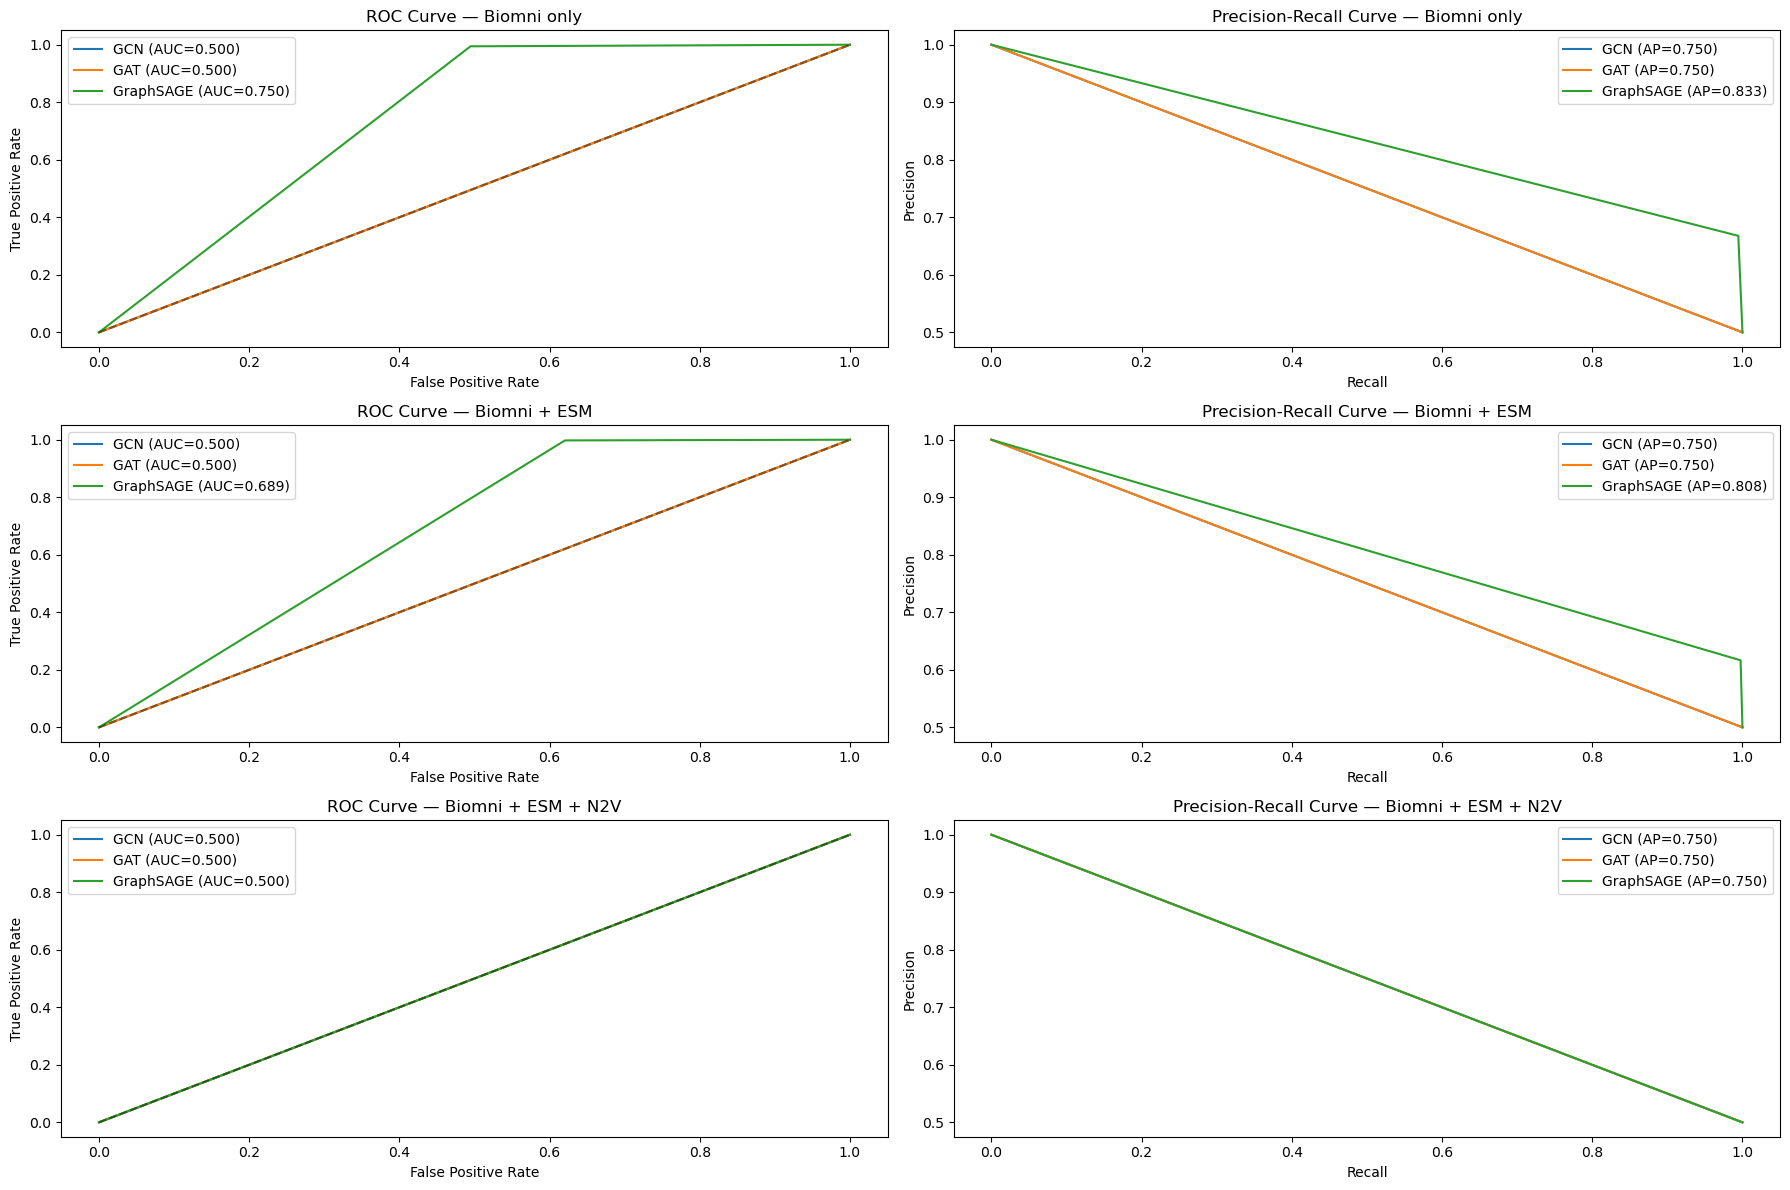


✅ Figure 2 saved as: Figure_2_ROC_PR_Curves.png


In [ ]:
# === FIGURE 2: ROC + PR CURVES FOR ALL FEATURE SETS AND MODELS ===
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc

def get_curves(model_class, in_dim, best_state, test_data):
    """Rebuild model, load weights, compute ROC/PR curves."""
    model = model_class(in_dim=in_dim).to(device)
    model.load_state_dict(best_state)
    model.eval()

    with torch.no_grad():
        logits = model(
            test_data.x.to(device),
            test_data.edge_index.to(device),
            test_data.edge_label_index.to(device),
        )
        probs = torch.sigmoid(logits).cpu().numpy()
        labels = test_data.edge_label.cpu().numpy()

    # ROC curve
    fpr, tpr, _ = roc_curve(labels, probs)
    roc_auc = auc(fpr, tpr)

    # PR curve
    precision, recall, _ = precision_recall_curve(labels, probs)
    pr_auc = auc(recall, precision)

    return (fpr, tpr, roc_auc, precision, recall, pr_auc)

# -----------------------------------------------------------
# Load results into a structured dictionary
# -----------------------------------------------------------
feature_sets = {
    "Biomni only":       (X_biomni, results_biomni),
    "Biomni + ESM":      (X_biomni_esm, results_biomni_esm),
    "Biomni + ESM + N2V": (X_biomni_esm_n2v, results_biomni_esm_n2v),
}

model_classes = {
    "GCN": GCNLinkPredictor,
    "GAT": GATLinkPredictor,
    "GraphSAGE": GraphSAGELinkPredictor
}

# -----------------------------------------------------------
# Create the figure
# -----------------------------------------------------------
plt.figure(figsize=(18, 12))

plot_idx = 1

for feature_name, (X_tensor, results) in feature_sets.items():

    test_data.x = X_tensor
    in_dim = X_tensor.shape[1]

    # -------------------- ROC CURVES ------------------------
    plt.subplot(3, 2, plot_idx)
    for res in results:
        model_name = res["model"]
        best_state = res["best_state"]
        cls = model_classes[model_name]

        fpr, tpr, roc_auc, precision, recall, pr_auc = get_curves(
            cls, in_dim, best_state, test_data
        )

        plt.plot(fpr, tpr, label=f"{model_name} (AUC={roc_auc:.3f})")

    plt.plot([0, 1], [0, 1], "k--", alpha=0.4)
    plt.title(f"ROC Curve — {feature_name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()

    # -------------------- PR CURVES -------------------------
    plt.subplot(3, 2, plot_idx + 1)
    for res in results:
        model_name = res["model"]
        best_state = res["best_state"]
        cls = model_classes[model_name]

        fpr, tpr, roc_auc, precision, recall, pr_auc = get_curves(
            cls, in_dim, best_state, test_data
        )

        plt.plot(recall, precision, label=f"{model_name} (AP={pr_auc:.3f})")

    plt.title(f"Precision-Recall Curve — {feature_name}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()

    plot_idx += 2

plt.tight_layout()
plt.savefig("Figure_2_ROC_PR_Curves.png", dpi=300)
plt.show()

print("\n✅ Figure 2 saved as: Figure_2_ROC_PR_Curves.png")


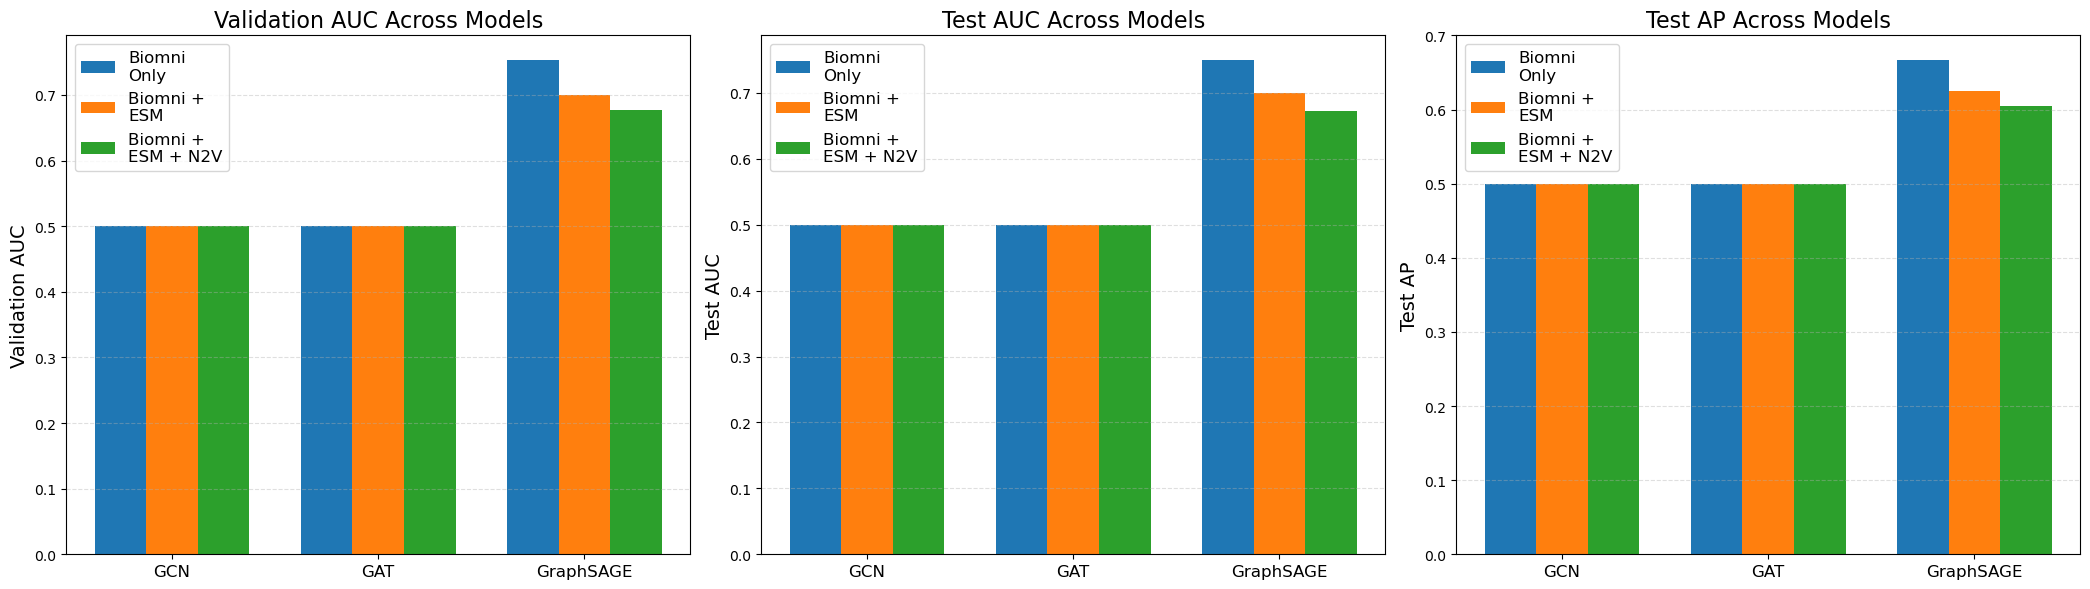


✅ Figure 3 saved as: Figure_3_Bar_Comparison.png


In [ ]:
# === FIGURE 3: Bar Chart Comparison of All Models & Feature Sets ===
import matplotlib.pyplot as plt
import numpy as np

# Organize results in a single structure
feature_sets = {
    "Biomni\nOnly": results_biomni,
    "Biomni +\nESM": results_biomni_esm,
    "Biomni +\nESM + N2V": results_biomni_esm_n2v
}

models = ["GCN", "GAT", "GraphSAGE"]
metrics = ["best_val_auc", "test_auc", "test_ap"]
metric_titles = ["Validation AUC", "Test AUC", "Test AP"]

# Extract matrix: feature_set x model x metric
data = np.zeros((3, 3, 3))  # [feature][model][metric]

for i, (fset, results) in enumerate(feature_sets.items()):
    for j, model_name in enumerate(models):
        r = next(res for res in results if res["model"] == model_name)
        data[i, j, 0] = r["best_val_auc"]
        data[i, j, 1] = r["test_auc"]
        data[i, j, 2] = r["test_ap"]

# ---------------- PLOT --------------------
fig, axs = plt.subplots(1, 3, figsize=(21, 6))

x = np.arange(len(models))
width = 0.25

for m in range(3):  # metric index
    ax = axs[m]
    for i, fset in enumerate(feature_sets.keys()):
        ax.bar(
            x + (i - 1) * width,
            data[i, :, m],
            width,
            label=fset
        )

    ax.set_xticks(x)
    ax.set_xticklabels(models, fontsize=12)
    ax.set_ylabel(metric_titles[m], fontsize=14)
    ax.set_title(metric_titles[m] + " Across Models", fontsize=16)
    ax.legend(fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.savefig("Figure_3_Bar_Comparison.png", dpi=300)
plt.show()

print("\n✅ Figure 3 saved as: Figure_3_Bar_Comparison.png")


=== GENERATING FIGURE 4: PRIORITY LINK HEATMAP ===
Best model selected: GraphSAGE
Best validation AUC: 0.6864
Strong predicted edges: 3563425

Priority-Class Link Table:


,Very Low,Low,Medium,High
Very Low,661,402,182,426
Low,402,0,0,197
Medium,182,0,0,101
High,426,197,101,31


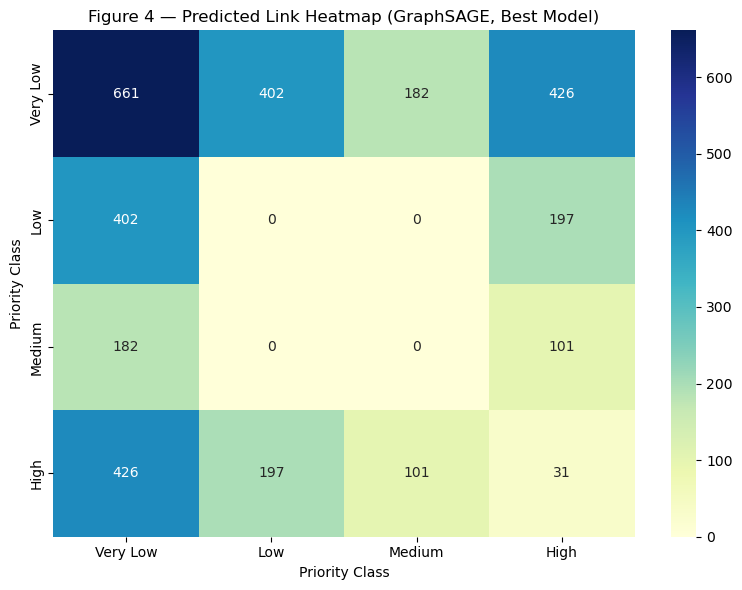

✅ FIGURE 4 saved as Figure_4_Priority_Link_Heatmap_1.png


In [15]:
# === FIGURE 4: PRIORITY-CLASS LINK HEATMAP (BEST MODEL) ===
import torch
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

print("=== GENERATING FIGURE 4: PRIORITY LINK HEATMAP ===")

# ------------------------------------------------------
# 1) Select Best Model Across All Feature Sets
# ------------------------------------------------------

def extract_best_model(results_list):
    """Return model name + best_state of the best model across feature set."""
    best_auc = -1
    best_info = None
    for results in results_list:
        for r in results:
            if r["best_val_auc"] > best_auc:
                best_auc = r["best_val_auc"]
                best_info = r
    return best_info

best_info = extract_best_model([
    results_biomni,
    results_biomni_esm,
    results_biomni_esm_n2v
])

best_model_name = best_info["model"]
best_state = best_info["best_state"]

print(f"Best model selected: {best_model_name}")
print(f"Best validation AUC: {best_info['best_val_auc']:.4f}")

# Pick correct class
if best_model_name == "GCN":
    ModelClass = GCNLinkPredictor
elif best_model_name == "GAT":
    ModelClass = GATLinkPredictor
else:
    ModelClass = GraphSAGELinkPredictor

# We must choose the SAME feature set where this model performed best
# Find feature tensor (biomni, esm, esm+n2v)
in_dim = None
if best_info in results_biomni:
    X_tensor = X_biomni
elif best_info in results_biomni_esm:
    X_tensor = X_biomni_esm
else:
    X_tensor = X_biomni_esm_n2v

in_dim = X_tensor.shape[1]

# ------------------------------------------------------
# 2) Load Best Model
# ------------------------------------------------------
best_model = ModelClass(in_dim=in_dim).to(device)
best_model.load_state_dict(best_state)
best_model.eval()

# Attach feature matrix to data
test_data.x = X_tensor

# ------------------------------------------------------
# 3) Encode node embeddings z
# ------------------------------------------------------
with torch.no_grad():
    z = best_model.encode(
        test_data.x.to(device),
        test_data.edge_index.to(device)
    )

# ------------------------------------------------------
# 4) Build candidate edges (original logic)
# ------------------------------------------------------

# Step: Identify isolated & connected nodes
isolated_nodes = [n for n, d in G_remapped.nodes(data=True) if d.get("isolated") == True]
connected_nodes = [n for n in G_remapped.nodes if n not in isolated_nodes]

node_to_idx = {name: i for i, name in enumerate(G_remapped.nodes)}
idx_to_node = {i: name for name, i in node_to_idx.items()}

candidate_edges = []

# Connect isolated → connected
for iso in isolated_nodes:
    for conn in connected_nodes:
        if not G_remapped.has_edge(iso, conn):
            candidate_edges.append((node_to_idx[iso], node_to_idx[conn]))

# Isolated → isolated pairs
for u, v in itertools.combinations(isolated_nodes, 2):
    if not G_remapped.has_edge(u, v):
        candidate_edges.append((node_to_idx[u], node_to_idx[v]))

candidate_edges = torch.tensor(candidate_edges, dtype=torch.long).t().contiguous().to(device)

# ------------------------------------------------------
# 5) Predict edge scores using dot product decoder
# ------------------------------------------------------
def decode_links(z, edge_index):
    src = z[edge_index[0]]
    dst = z[edge_index[1]]
    return (src * dst).sum(dim=-1)

with torch.no_grad():
    scores = decode_links(z, candidate_edges)
    probs = torch.sigmoid(scores)

# Filter strong edges (>= 0.90 probability)
threshold = 0.90
mask = probs >= threshold
strong_edges = candidate_edges[:, mask]
strong_probs = probs[mask]

print("Strong predicted edges:", strong_edges.shape[1])

# Limit to top-K edges for heatmap clarity
TOP_K = 2000
if strong_edges.size(1) > TOP_K:
    top_probs, top_idx = torch.topk(strong_probs, TOP_K)
    strong_edges = strong_edges[:, top_idx]

# ------------------------------------------------------
# 6) Priority-Class Counting
# ------------------------------------------------------
priority_dict = {name: G_remapped.nodes[name]["priority"] for name in G_remapped.nodes}

pair_counter = Counter()

for i in range(strong_edges.size(1)):
    u_idx = strong_edges[0, i].item()
    v_idx = strong_edges[1, i].item()
    u_name = idx_to_node[u_idx]
    v_name = idx_to_node[v_idx]
    a = priority_dict[u_name]
    b = priority_dict[v_name]
    key = tuple(sorted((a, b)))
    pair_counter[key] += 1

# ------------------------------------------------------
# 7) Build priority matrix for heatmap
# ------------------------------------------------------
priority_labels = ["Very Low", "Low", "Medium", "High"]
n = len(priority_labels)

import pandas as pd
heatmap_table = pd.DataFrame(0, index=priority_labels, columns=priority_labels)

for (a, b), count in pair_counter.items():
    A = priority_labels[a]
    B = priority_labels[b]
    heatmap_table.loc[A, B] += count
    if A != B:
        heatmap_table.loc[B, A] += count  # keep symmetric

print("\nPriority-Class Link Table:")
display(heatmap_table)

# ------------------------------------------------------
# 8) Plot Heatmap
# ------------------------------------------------------
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_table, annot=True, fmt='d', cmap="YlGnBu", cbar=True)
plt.title(f"Figure 4 — Predicted Link Heatmap ({best_model_name}, Best Model)")
plt.xlabel("Priority Class")
plt.ylabel("Priority Class")
plt.tight_layout()
plt.savefig("Figure_4_Priority_Link_Heatmap_1.png", dpi=300)
plt.show()

print("✅ FIGURE 4 saved as Figure_4_Priority_Link_Heatmap_1.png")


In [ ]:
# === COMPARATIVE TABLE ACROSS ALL FEATURE SETS ===
import pandas as pd

def results_to_df(name, results):
    rows = []
    for r in results:
        rows.append([
            name,
            r["model"],
            r["best_val_auc"],
            r["test_auc"],
            r["test_ap"],
            r["best_epoch"]
        ])
    return rows

rows = []
rows += results_to_df("Biomni", results_biomni)
rows += results_to_df("Biomni + ESM", results_biomni_esm)
rows += results_to_df("Biomni + ESM + Node2Vec", results_biomni_esm_n2v)

df_perf = pd.DataFrame(rows, columns=[
    "Feature Set", "Model", "Best Val AUC", "Test AUC", "Test AP", "Best Epoch"
])

display(df_perf)

df_perf.to_csv("Figure_3_GNN_Comparative_Performance.csv", index=False)
print("Saved: Figure_3_GNN_Comparative_Performance.csv")

# LaTeX table
latex_table = df_perf.to_latex(index=False, float_format="%.3f")
with open("Figure_3_GNN_Comparative_Performance.tex", "w") as f:
    f.write(latex_table)

print("Saved: Figure_3_GNN_Comparative_Performance.tex")


,Feature Set,Model,Best Val AUC,Test AUC,Test AP,Best Epoch
0,Biomni,GCN,0.500000,0.500000,0.500000,1
1,Biomni,GAT,0.500000,0.500000,0.500000,1
2,Biomni,GraphSAGE,0.753219,0.749847,0.666839,50
3,Biomni + ESM,GCN,0.500000,0.500000,0.500000,1
4,Biomni + ESM,GAT,0.500000,0.500000,0.500000,1
5,Biomni + ESM,GraphSAGE,0.700490,0.699877,0.625392,6
6,Biomni + ESM + Node2Vec,GCN,0.500000,0.500000,0.500000,1
7,Biomni + ESM + Node2Vec,GAT,0.500000,0.500000,0.500000,1
8,Biomni + ESM + Node2Vec,GraphSAGE,0.676579,0.672287,0.604357,7


Saved: Figure_3_GNN_Comparative_Performance.csv
Saved: Figure_3_GNN_Comparative_Performance.tex


In [ ]:
# === FIGURE 5: 2D VISUALIZATION OF GNN FINAL EMBEDDINGS ===

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

print("=== Figure 5: Embedding Visualization ===")

# Encode once more
with torch.no_grad():
    z = best_model.encode(
        X_tensor.to(device),
        test_data.edge_index.to(device)
    ).cpu().numpy()

# t-SNE to 2D
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)
z_2d = tsne.fit_transform(z)

priority_vec = [G_remapped.nodes[n]["priority"] for n in G_remapped.nodes]
priority_labels = ["Very Low","Low","Medium","High"]
colors = ["gray","blue","orange","red"]

plt.figure(figsize=(9,7))
for p in range(4):
    mask = [i for i,val in enumerate(priority_vec) if val==p]
    plt.scatter(
        z_2d[mask,0], z_2d[mask,1],
        c=colors[p], s=25, alpha=0.7, label=priority_labels[p]
    )

plt.title(f"Figure 5 — t-SNE Visualization of GNN Embeddings ({best_model_name})")
plt.legend()
plt.tight_layout()
plt.savefig("Figure_5_GNN_Embedding_TSNE.png", dpi=300)
plt.show()


=== Figure 5: Embedding Visualization ===


: 

=== Figure 6: Network Visualization ===


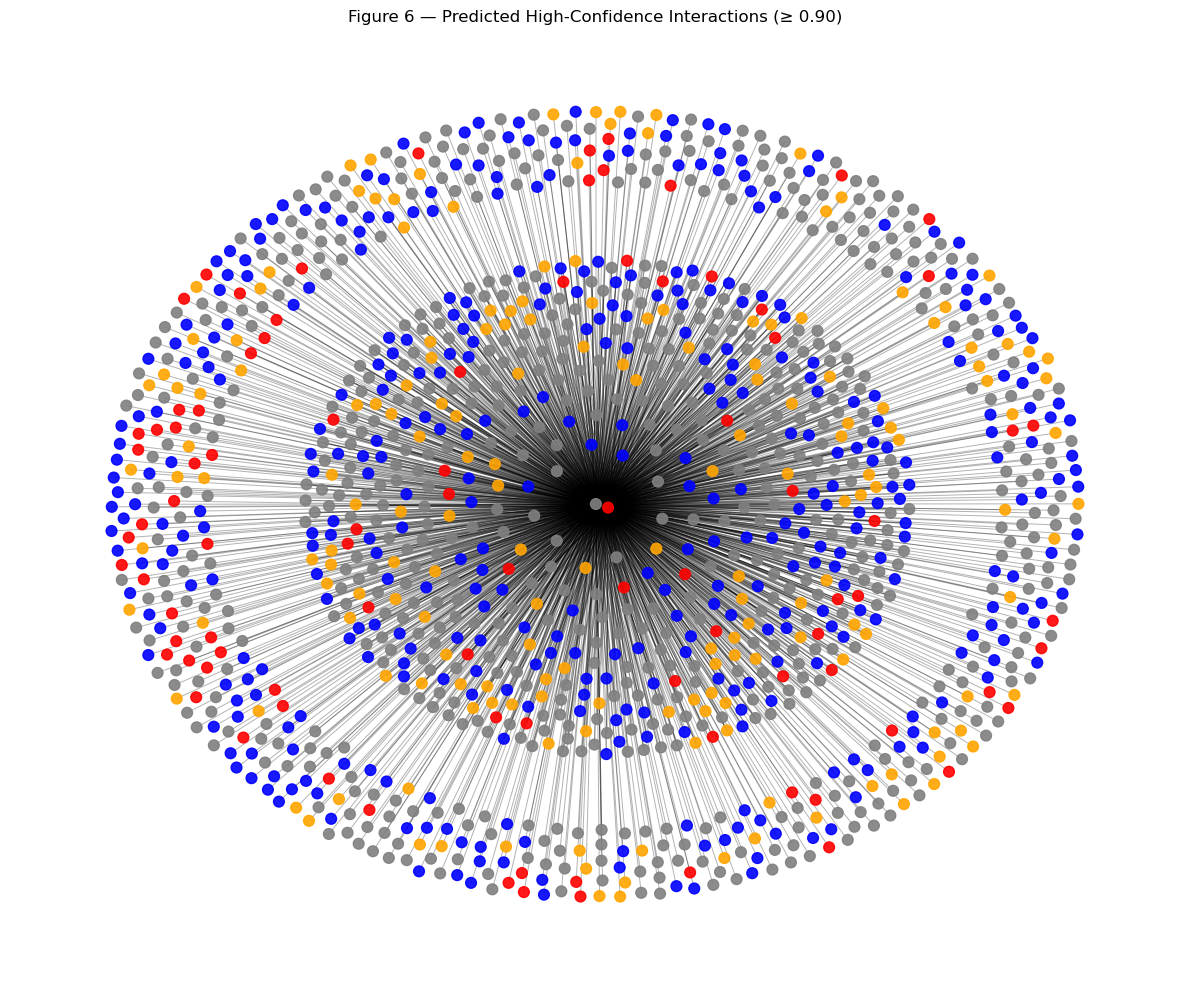

Saved: Figure_6_Predicted_Network_1.png


In [16]:
# === FIGURE 6 — NETWORK GRAPH OF PREDICTED LINKS (≥ 0.90) ===
import networkx as nx
import matplotlib.pyplot as plt

print("=== Figure 6: Network Visualization ===")

# 1) Build a new graph of predicted strong links
G_pred = nx.Graph()

for i in range(strong_edges.size(1)):
    u = strong_edges[0, i].item()
    v = strong_edges[1, i].item()
    u_name = idx_to_node[u]
    v_name = idx_to_node[v]
    G_pred.add_edge(u_name, v_name)

# Assign node attributes
for n in G_pred.nodes():
    G_pred.nodes[n]["priority"] = G_remapped.nodes[n]["priority"]

# Colors
priority_colors = {0:"gray", 1:"blue", 2:"orange", 3:"red"}
node_colors = [priority_colors[G_pred.nodes[n]["priority"]] for n in G_pred.nodes()]

# Layout
pos = nx.spring_layout(G_pred, k=0.30, iterations=60)

plt.figure(figsize=(12,10))
nx.draw_networkx_nodes(G_pred, pos, node_size=60, node_color=node_colors, alpha=0.9)
nx.draw_networkx_edges(G_pred, pos, alpha=0.3, width=0.7)

plt.title("Figure 6 — Predicted High-Confidence Interactions (≥ 0.90)")
plt.axis("off")
plt.tight_layout()
plt.savefig("Figure_6_Predicted_Network_1.png", dpi=300)
plt.show()

print("Saved: Figure_6_Predicted_Network_1.png")


Embeddings: (1644, 64)
Points kept after trimming: 1070


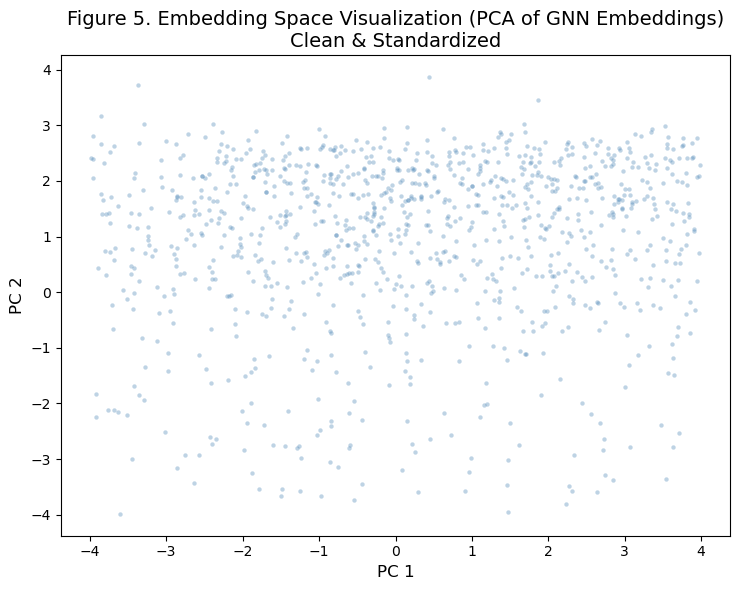

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# ---- Load embeddings ----
z = torch.load("Results/GraphSAGE/embeddings_best.pt", map_location="cpu").numpy()

print("Embeddings:", z.shape)

# ---- Standardize ----
scaler = StandardScaler()
z_scaled = scaler.fit_transform(z)

# ---- PCA (2 components) ----
pca = PCA(n_components=2, random_state=42)
z_pca = pca.fit_transform(z_scaled)

# ---- Remove extreme outliers (optional but recommended) ----
# Keep points within |z| < 4 SD on both PC axes
mask = (np.abs(z_pca[:, 0]) < 4) & (np.abs(z_pca[:, 1]) < 4)
z_clean = z_pca[mask]

print("Points kept after trimming:", len(z_clean))

# ---- Plot ----
plt.figure(figsize=(7.5, 6))
plt.scatter(
    z_clean[:, 0], z_clean[:, 1],
    s=10, alpha=0.35, linewidth=0,
    color="steelblue"
)

plt.xlabel("PC 1", fontsize=12)
plt.ylabel("PC 2", fontsize=12)
plt.title("Figure 5. Embedding Space Visualization (PCA of GNN Embeddings)\nClean & Standardized", fontsize=14)

plt.grid(False)
plt.tight_layout()
plt.show()


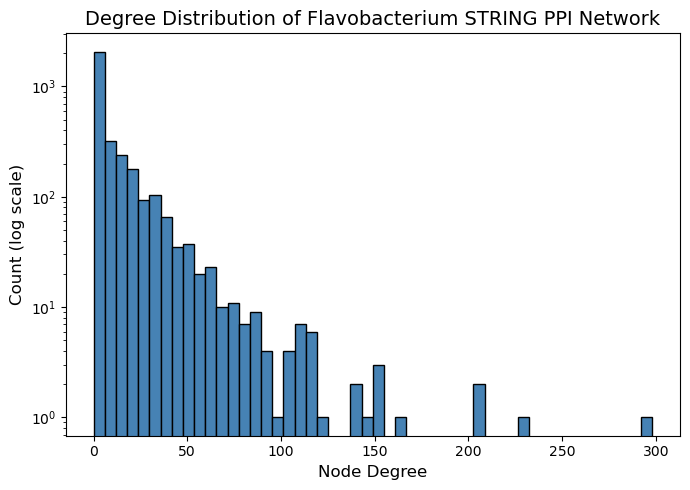

In [17]:
# === DEGREE DISTRIBUTION FIGURE ===
import matplotlib.pyplot as plt
import numpy as np

degrees = [deg for _, deg in G_remapped.degree()]
plt.figure(figsize=(7,5))
plt.hist(degrees, bins=50, color='steelblue', edgecolor='black')
plt.yscale("log")
plt.xlabel("Node Degree", fontsize=12)
plt.ylabel("Count (log scale)", fontsize=12)
plt.title("Degree Distribution of Flavobacterium STRING PPI Network", fontsize=14)
plt.tight_layout()
plt.savefig("Figure_A1_Degree_Distribution.png", dpi=300)
plt.show()


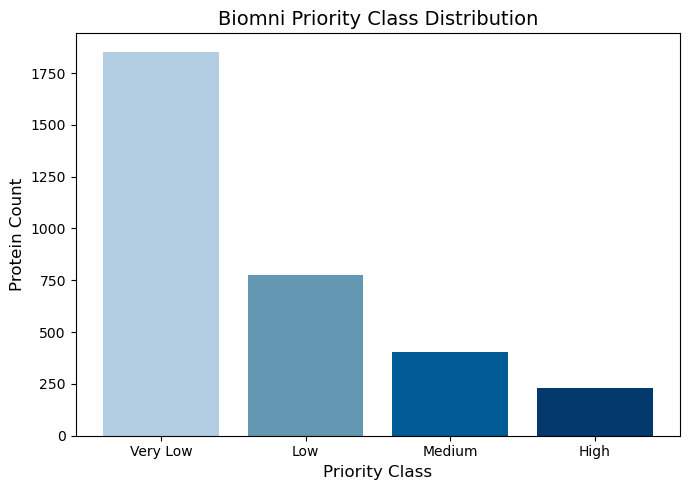

In [18]:
# === PRIORITY CLASS DISTRIBUTION ===
import matplotlib.pyplot as plt
from collections import Counter

priority_map_rev = {0: "Very Low", 1: "Low", 2: "Medium", 3: "High"}

priority_list = [
    G_remapped.nodes[n]["priority"]
    for n in G_remapped.nodes
    if G_remapped.nodes[n]["priority"] >= 0
]

counts = Counter(priority_list)

labels = [priority_map_rev[k] for k in sorted(counts.keys())]
values = [counts[k] for k in sorted(counts.keys())]

plt.figure(figsize=(7,5))
plt.bar(labels, values, color=["#b3cde3","#6497b1","#005b96","#03396c"])
plt.xlabel("Priority Class", fontsize=12)
plt.ylabel("Protein Count", fontsize=12)
plt.title("Biomni Priority Class Distribution", fontsize=14)
plt.tight_layout()
plt.savefig("Figure_A2_Priority_Distribution.png", dpi=300)
plt.show()


In [23]:
import csv
import os

LOG_DIR = "training_logs"
os.makedirs(LOG_DIR, exist_ok=True)

def init_log_file(model_name, feature_name):
    path = f"{LOG_DIR}/{model_name}_{feature_name}.csv"
    with open(path, "w") as f:
        writer = csv.writer(f)
        writer.writerow(["epoch", "train_loss", "val_auc", "val_ap"])
    return path

def append_log(path, epoch, loss, val_auc, val_ap):
    with open(path, "a") as f:
        writer = csv.writer(f)
        writer.writerow([epoch, loss, val_auc, val_ap])



In [24]:
def run_single_model(model_name, ModelClass, in_dim, train_data, val_data, test_data,
                     hidden_dim=128, lr=1e-3, max_epochs=50, patience=10,
                     feature_name="unknown"):

    # init log file
    log_path = init_log_file(model_name, feature_name)

    model = ModelClass(in_dim=in_dim, hidden_dim=hidden_dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_val_auc = 0.0
    best_test_auc = 0.0
    best_test_ap = 0.0
    best_epoch = 0
    best_state = None
    no_improve = 0

    for epoch in range(1, max_epochs + 1):
        loss = train_one_epoch(model, train_data, optimizer)
        val_auc, val_ap = eval_auc_ap(model, val_data)

        print(f"[{model_name}][Epoch {epoch}] loss={loss:.4f} val_AUC={val_auc:.3f} val_AP={val_ap:.3f}")

        # <-- LOG EACH EPOCH
        append_log(log_path, epoch, loss, val_auc, val_ap)

        if val_auc > best_val_auc + 1e-4:
            best_val_auc = val_auc
            best_epoch = epoch
            no_improve = 0
            test_auc, test_ap = eval_auc_ap(model, test_data)
            best_test_auc = test_auc
            best_test_ap = test_ap
            best_state = model.state_dict()
        else:
            no_improve += 1
            if no_improve >= patience:
                print("⏹ Early stopping.")
                break

    print(f"🏆 {model_name}: Best Val AUC={best_val_auc:.3f} | "
          f"Test AUC={best_test_auc:.3f}, AP={best_test_ap:.3f}")

    return {
        "model": model_name,
        "best_val_auc": float(best_val_auc),
        "test_auc": float(best_test_auc),
        "test_ap": float(best_test_ap),
        "best_epoch": best_epoch,
        "best_state": best_state,
        "feature_set": feature_name,
    }


In [25]:
# === RUN TRAINING WITH LOGGING ENABLED ===

# assign features into the splits
train_data.x = X_biomni_esm_n2v
val_data.x   = X_biomni_esm_n2v
test_data.x  = X_biomni_esm_n2v

in_dim = X_biomni_esm_n2v.shape[1]
feature_name = "Biomni_ESM_Node2Vec"

print("Running GCN...")
results_gcn = run_single_model(
    "GCN",
    GCNLinkPredictor,
    in_dim,
    train_data,
    val_data,
    test_data,
    feature_name=feature_name
)

print("\nRunning GAT...")
results_gat = run_single_model(
    "GAT",
    GATLinkPredictor,
    in_dim,
    train_data,
    val_data,
    test_data,
    feature_name=feature_name
)

print("\nRunning GraphSAGE...")
results_sage = run_single_model(
    "GraphSAGE",
    GraphSAGELinkPredictor,
    in_dim,
    train_data,
    val_data,
    test_data,
    feature_name=feature_name
)

print("\n=== TRAINING COMPLETE ===")
print("GCN:", results_gcn)
print("GAT:", results_gat)
print("GraphSAGE:", results_sage)


Running GCN...
[GCN][Epoch 1] loss=88446088.0000 val_AUC=0.500 val_AP=0.500
[GCN][Epoch 2] loss=76339240.0000 val_AUC=0.500 val_AP=0.500
[GCN][Epoch 3] loss=63044096.0000 val_AUC=0.500 val_AP=0.500
[GCN][Epoch 4] loss=54004044.0000 val_AUC=0.500 val_AP=0.500
[GCN][Epoch 5] loss=45582328.0000 val_AUC=0.500 val_AP=0.500
[GCN][Epoch 6] loss=38138128.0000 val_AUC=0.500 val_AP=0.500
[GCN][Epoch 7] loss=31691100.0000 val_AUC=0.500 val_AP=0.500
[GCN][Epoch 8] loss=26630786.0000 val_AUC=0.500 val_AP=0.500
[GCN][Epoch 9] loss=22155828.0000 val_AUC=0.500 val_AP=0.500
[GCN][Epoch 10] loss=17734254.0000 val_AUC=0.500 val_AP=0.500
[GCN][Epoch 11] loss=14845600.0000 val_AUC=0.500 val_AP=0.500
⏹ Early stopping.
🏆 GCN: Best Val AUC=0.500 | Test AUC=0.500, AP=0.500

Running GAT...
[GAT][Epoch 1] loss=392906400.0000 val_AUC=0.500 val_AP=0.500
[GAT][Epoch 2] loss=318033440.0000 val_AUC=0.500 val_AP=0.500
[GAT][Epoch 3] loss=384621248.0000 val_AUC=0.500 val_AP=0.500
[GAT][Epoch 4] loss=308855424.0000 val_

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_loss(model_name, feature_name):
    path = f"training_logs/{model_name}_{feature_name}.csv"
    df = pd.read_csv(path)

    plt.figure(figsize=(7,5))
    plt.plot(df["epoch"], df["train_loss"], label="Train Loss", linewidth=2)
    plt.plot(df["epoch"], df["val_auc"], label="Validation AUC", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("Metric Value")
    plt.title(f"{model_name} Training Curve ({feature_name})")
    plt.legend()
    plt.grid(True)
    plt.show()


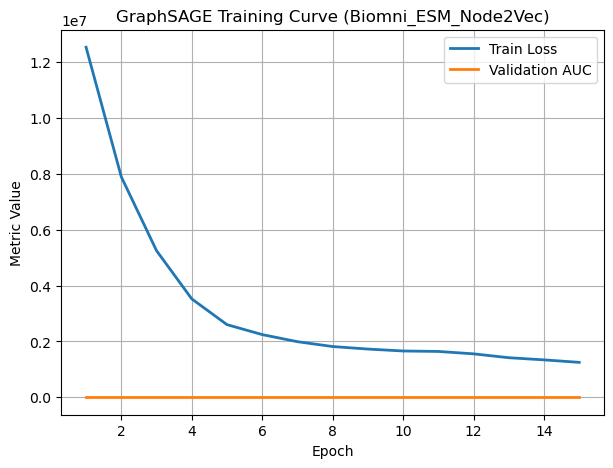

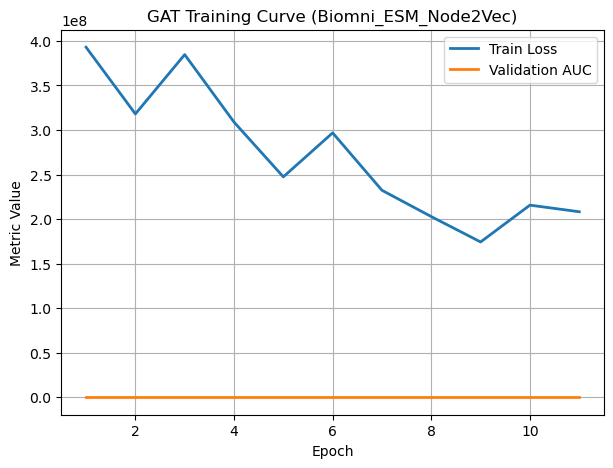

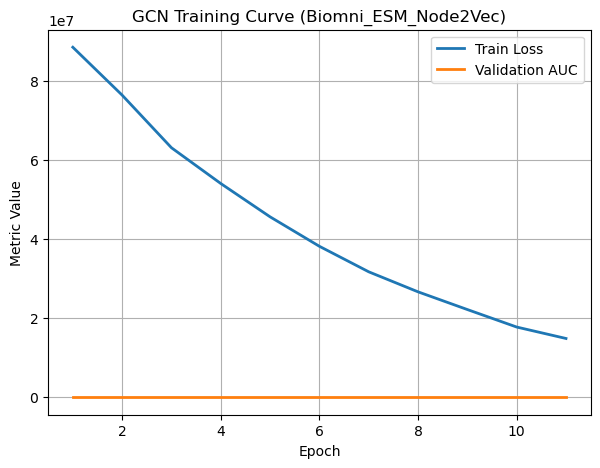

In [27]:
plot_loss("GraphSAGE", "Biomni_ESM_Node2Vec")
plot_loss("GAT", "Biomni_ESM_Node2Vec")
plot_loss("GCN", "Biomni_ESM_Node2Vec")


In [29]:
# ======================================================
# FIXED ABLATION FEATURE CONSTRUCTION
# ======================================================

import numpy as np
import torch

print("=== Building Ablation Feature Matrices ===")

# The dicts esm_emb and node2vec_emb already loaded in earlier cells
# ordered_nodes and dims are known

# ----------------------------------
# Build ESM-only Feature Matrix
# ----------------------------------
X_esm_only = []

for pid in ordered_nodes:
    vec = esm_emb[pid] if esm_emb[pid] is not None else np.zeros(ESM_DIM)
    X_esm_only.append(vec)

X_esm_only = torch.tensor(np.vstack(X_esm_only), dtype=torch.float)
print("ESM-only matrix:", X_esm_only.shape)

# ----------------------------------
# Build Node2Vec-only Feature Matrix
# ----------------------------------
X_n2v_only = []

for pid in ordered_nodes:
    vec = node2vec_emb[pid] if node2vec_emb[pid] is not None else np.zeros(NODE2VEC_DIM)
    X_n2v_only.append(vec)

X_n2v_only = torch.tensor(np.vstack(X_n2v_only), dtype=torch.float)
print("Node2Vec-only matrix:", X_n2v_only.shape)

# ----------------------------------
# Build Biomni + Node2Vec Matrix
# ----------------------------------
X_biomni_n2v = torch.tensor(
    np.concatenate([X_biomni.numpy(), np.vstack(X_n2v_only)], axis=1),
    dtype=torch.float
)
print("Biomni + Node2Vec:", X_biomni_n2v.shape)

print("=== Ablation Feature Matrices READY ===")


=== Building Ablation Feature Matrices ===
ESM-only matrix: torch.Size([3257, 480])
Node2Vec-only matrix: torch.Size([3257, 128])
Biomni + Node2Vec: torch.Size([3257, 137])
=== Ablation Feature Matrices READY ===


In [31]:
# ======================================================
# ABLATION STUDY — GraphSAGE with Reduced Feature Sets
# ======================================================

print("=== Running GRAPH SAGE ABLATION EXPERIMENTS ===")

def update_features(dataset, feats):
    """Assign new feature matrix while preserving node indexing."""
    dataset = dataset.clone()
    dataset.x = feats
    return dataset

ablation_results = {}

# ======================================================
# A1: ESM-only features
# ======================================================
train_esm = update_features(train_data, X_esm_only)
val_esm   = update_features(val_data,   X_esm_only)
test_esm  = update_features(test_data,  X_esm_only)

ablation_results["ESM_only"] = run_single_model(
    model_name="GraphSAGE_ESM_only",
    ModelClass=GraphSAGELinkPredictor,
    in_dim=X_esm_only.shape[1],
    train_data=train_esm,
    val_data=val_esm,
    test_data=test_esm,
    feature_name="ESM_only"
)

# ======================================================
# A2: Node2Vec-only features
# ======================================================
train_n2v = update_features(train_data, X_n2v_only)
val_n2v   = update_features(val_data,   X_n2v_only)
test_n2v  = update_features(test_data,  X_n2v_only)

ablation_results["Node2Vec_only"] = run_single_model(
    model_name="GraphSAGE_Node2Vec_only",
    ModelClass=GraphSAGELinkPredictor,
    in_dim=X_n2v_only.shape[1],
    train_data=train_n2v,
    val_data=val_n2v,
    test_data=test_n2v,
    feature_name="Node2Vec_only"
)

# ======================================================
# A3: Biomni + Node2Vec
# ======================================================
train_bn2v = update_features(train_data, X_biomni_n2v)
val_bn2v   = update_features(val_data,   X_biomni_n2v)
test_bn2v  = update_features(test_data,  X_biomni_n2v)

ablation_results["Biomni+Node2Vec"] = run_single_model(
    model_name="GraphSAGE_Biomni_Node2Vec",
    ModelClass=GraphSAGELinkPredictor,
    in_dim=X_biomni_n2v.shape[1],
    train_data=train_bn2v,
    val_data=val_bn2v,
    test_data=test_bn2v,
    feature_name="Biomni_Node2Vec"
)

# ======================================================
# PRINT RESULTS
# ======================================================
print("\n=== FINAL ABLATION RESULTS ===")
for name, result in ablation_results.items():
    print(f"{name}: {result}")


=== Running GRAPH SAGE ABLATION EXPERIMENTS ===
[GraphSAGE_ESM_only][Epoch 1] loss=0.6767 val_AUC=0.909 val_AP=0.866
[GraphSAGE_ESM_only][Epoch 2] loss=0.6174 val_AUC=0.914 val_AP=0.882
[GraphSAGE_ESM_only][Epoch 3] loss=0.5836 val_AUC=0.916 val_AP=0.891
[GraphSAGE_ESM_only][Epoch 4] loss=0.5595 val_AUC=0.918 val_AP=0.897
[GraphSAGE_ESM_only][Epoch 5] loss=0.5410 val_AUC=0.920 val_AP=0.901
[GraphSAGE_ESM_only][Epoch 6] loss=0.5248 val_AUC=0.921 val_AP=0.904
[GraphSAGE_ESM_only][Epoch 7] loss=0.5199 val_AUC=0.922 val_AP=0.905
[GraphSAGE_ESM_only][Epoch 8] loss=0.5138 val_AUC=0.922 val_AP=0.906
[GraphSAGE_ESM_only][Epoch 9] loss=0.5148 val_AUC=0.922 val_AP=0.907
[GraphSAGE_ESM_only][Epoch 10] loss=0.5131 val_AUC=0.923 val_AP=0.907
[GraphSAGE_ESM_only][Epoch 11] loss=0.5107 val_AUC=0.924 val_AP=0.909
[GraphSAGE_ESM_only][Epoch 12] loss=0.5106 val_AUC=0.926 val_AP=0.911
[GraphSAGE_ESM_only][Epoch 13] loss=0.5067 val_AUC=0.928 val_AP=0.913
[GraphSAGE_ESM_only][Epoch 14] loss=0.5045 val_AUC=

In [ ]:
/Users/muhammadkazim/Downloads/USDA_Project/USDA_Project/link_prediction_experiment.ipynb